In [39]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import joblib


In [40]:
df = pd.read_csv("dataset.csv")
df.head()


,batter,venue,opponent_team,runs_avg_last_5,runs_avg_last_10,venue_avg_runs,opponent_avg_runs,career_avg_runs,career_matches,target_runs_next_match
0,A Ashish Reddy,Wankhede Stadium,Mumbai Indians,0.0,0.0,10.000000,13.500000,0.00,0,3.0
1,A Ashish Reddy,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,0.0,0.0,19.500000,15.000000,10.00,1,8.0
2,A Ashish Reddy,"Rajiv Gandhi International Stadium, Uppal",Kings XI Punjab,0.0,0.0,8.454545,12.333333,6.50,2,10.0
3,A Ashish Reddy,"Rajiv Gandhi International Stadium, Uppal",Rajasthan Royals,0.0,0.0,8.454545,12.333333,7.00,3,4.0
4,A Ashish Reddy,"Rajiv Gandhi International Stadium, Uppal",Royal Challengers Bangalore,0.0,0.0,8.454545,11.000000,7.75,4,7.0


In [41]:
y = df["target_runs_next_match"]


In [42]:
X = df.drop(columns=["target_runs_next_match"], errors="ignore")

X = X.select_dtypes(include=[np.number])


In [43]:
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]


In [44]:
baseline_pred = X_test["runs_avg_last_10"]

baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline RMSE:", baseline_rmse)
print("Baseline MAE:", baseline_mae)
print("Baseline R2:", baseline_r2)


Baseline RMSE: 22.697184536669162
Baseline MAE: 16.497487132909477
Baseline R2: -0.048289221955144734


In [45]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest MAE:", rf_mae)
print("Random Forest R2:", rf_r2)


Random Forest RMSE: 20.817145927198723
Random Forest MAE: 15.500978840773326
Random Forest R2: 0.1181808691337477


In [46]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost RMSE:", xgb_rmse)
print("XGBoost MAE:", xgb_mae)
print("XGBoost R2:", xgb_r2)


XGBoost RMSE: 21.30360328453804
XGBoost MAE: 15.720372143565545
XGBoost R2: 0.07648644240234037


In [47]:
lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)

lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_test)

lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
lgbm_mae = mean_absolute_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)

print("LightGBM RMSE:", lgbm_rmse)
print("LightGBM MAE:", lgbm_mae)
print("LightGBM R2:", lgbm_r2)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 13212, number of used features: 6
[LightGBM] [Info] Start training from score 19.287920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [48]:
from sklearn.model_selection import GridSearchCV


In [49]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [8, 10],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 3]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [8, 10], 'min_samples_leaf': [2, 3], 'min_samples_split': [5, 10], 'n_estimators': [200, 300]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [50]:
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}


In [57]:
best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost RMSE:", rmse)
print("XGBoost MAE:", mae)
print("XGBoost R2:", r2)


XGBoost RMSE: 20.753734061898122
XGBoost MAE: 15.451469069652541
XGBoost R2: 0.12354496943119464


In [58]:
joblib.dump(best_xgb, "xgb_model.joblib")


['xgb_model.joblib']

In [54]:
import shap

In [55]:
explainer = shap.TreeExplainer(best_xgb)

X_shap = X_train.sample(100, random_state=42)
shap_values = explainer.shap_values(X_shap)


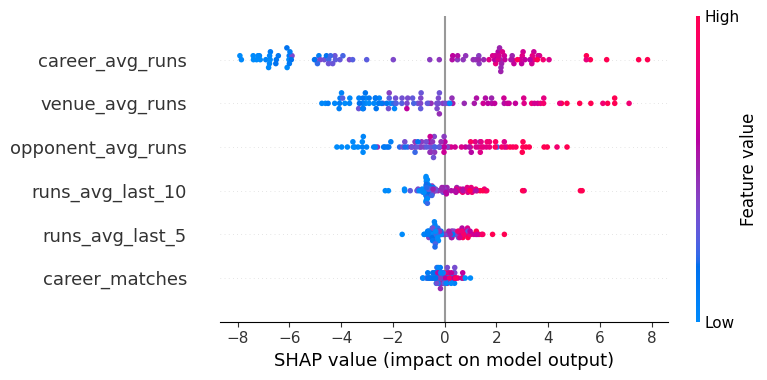

In [56]:
shap.summary_plot(shap_values, X_shap)
